In [ ]:
# example-landau-fit-for-bool-ode-data.ipynb
#
# Bryan Daniels
# 2023/10/25
#
# Example of running the "Landau" data analysis code (found 
# here: https://github.com/Collective-Logic-Lab/landau )
# on data produced by BoolODE.
#
# Much of this code was forked from what I wrote for the
# Spring 2023 grant proposal, found in 
# Control-of-Synthetic-Boolean-Networks/code/BoolODE_data.ipynb
#

# load BoolODE data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm # for progress bars

In [70]:
# read expression data into pandas DataFrame

# data from a single initial condition
# dataDir = '../Bool ODE outputs/pRogress_4/'
# expression = pd.read_csv('{}/ExpressionData.csv'.format(dataDir),
#                          index_col=0).T

# 240320 data from random initial conditions, larger timestep of 0.01 (I think)
# dataDir = '../Bool ODE outputs/240320'
# expression = pd.read_csv('{}/sampled_1000cells_1000timesteps.csv'.format(dataDir),
#                          index_col=0).T

# 2025/1/23 data from random initial conditions and smaller timestep of 0.001 (I think)
dataDir = '../Bool ODE outputs/cordicalAreaFixedCode'
expression = pd.read_csv('{}/sampled_ExpData.csv'.format(dataDir),
                         index_col=0).T

In [71]:
# look at the DataFrame to see what we're working with
# (here 1000 cells with 5 gene expressions each)
expression

,g1,g2,g3,g4,g5
E0_735,1.871765,0.002290,0.000044,0.000908,0.000490
E0_647,1.930443,0.000205,0.000569,0.000059,0.000235
E0_285,0.000385,0.000022,1.854529,0.942337,0.247919
E0_692,0.000386,0.003915,0.000009,0.001234,0.000912
E0_646,1.937128,0.000164,0.000513,0.000228,0.000010
...,...,...,...,...,...
E0_546,2.193405,0.029557,0.000003,0.000597,0.000181
E0_246.1,1.931288,0.000125,0.000015,0.000327,0.001766
E0_872.1,0.000106,0.000692,1.779714,2.008410,1.428463
E0_859,1.332040,0.000897,0.000052,0.028156,0.001948


In the BoolODE data, we know the timepoint at which each cell was sampled.  (In real data, we won't know this, but we'll deal with this fact later using RNA velocity.)  In BoolODE, the relevant time is known as the "pseudotime" (I think).  We load these times here from the file "PseudoTime.csv":

In [72]:
try:
    # read times from the BoolODE file if it is there
    times_raw = pd.read_csv('{}/PseudoTime.csv'.format(dataDir),
                           index_col=0)
    # keep just the 'PseudoTime' column and just the rows corresponding 
    # to the sampled cells (those in expression.index)
    times = times_raw['PseudoTime'].loc[expression.index]
except FileNotFoundError:
    # if there is no PseudoTime file, take times from names listed in the index of the dataframe
    # NOTE: pandas puts suffixes ".1", ".2", etc for rows with repeated names 
    # --- e.g. if we have two cells sampled at the same timestep 353, we get columns "E0_353" and "E0_353.1"
    times_list = [ np.floor(float(name[3:])) for name in expression.index ]
    times = pd.Series(times_list,index=expression.index)

In [73]:
times

E0_735      735.0
E0_647      647.0
E0_285      285.0
E0_692      692.0
E0_646      646.0
            ...  
E0_546      546.0
E0_246.1    246.0
E0_872.1    872.0
E0_859      859.0
E0_303.1    303.0
Length: 1000, dtype: float64

# do landau analysis to highlight potential control nodes

In [74]:
from landau import landauAnalysis

For the analysis, we want to split the cells into sub-populations that all have similar pseudotime.  So we will pick time windows that include enough cells — let's try for roughly 50 cells per time window.  We split to include a constant number of cells in each window.

In [75]:
times.sort_values()

E0_1          1.0
E0_1.1        1.0
E0_3          3.0
E0_4          4.0
E0_7          7.0
            ...  
E0_995      995.0
E0_995.1    995.0
E0_997.1    997.0
E0_997      997.0
E0_998      998.0
Length: 1000, dtype: float64

In [76]:
times.sort_values().index

Index(['E0_1', 'E0_1.1', 'E0_3', 'E0_4', 'E0_7', 'E0_7.1', 'E0_8.2', 'E0_8',
       'E0_8.1', 'E0_9.1',
       ...
       'E0_988', 'E0_989', 'E0_991', 'E0_992', 'E0_993', 'E0_995', 'E0_995.1',
       'E0_997.1', 'E0_997', 'E0_998'],
      dtype='object', length=1000)

In [77]:
len(np.unique(times))

641

In [78]:
# set up a series of time windows
cells_to_use_list = []

# use fixed number of windows of equal width in time
# Nwindows = 50 #30 #20 #10
# t_min_list = np.linspace(0,1,Nwindows)
# delta_t = t_min_list[1] - t_min_list[0]
# for t_min in t_min_list:
#     # restrict to varying time window
#     t_max = t_min+delta_t
#     cells_to_use = (times >= t_min) & (times < t_max)
#     cells_to_use_list.append(cells_to_use)

# use groups of cells with fixed size
cellsPerGroup = 100 #20
deltaCells = 10 # number of cells to move between groups (e.g. deltaCells=cellsPerGroup gives non-overlapping groups)
numGroups = int(np.floor((len(times)-cellsPerGroup)/deltaCells))
t_min_list = []
for i in range(numGroups):
    times_to_use = times.sort_values()[deltaCells*i:(deltaCells*i+cellsPerGroup)]
    cells_to_use_list.append(list(times_to_use.index))
    t_min_list.append(min(times_to_use))

90 groups, with average size 100.0


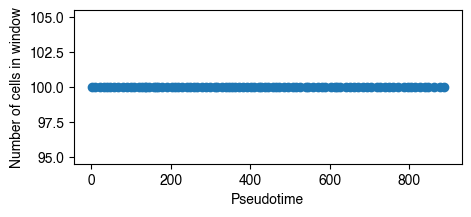

In [79]:
plt.figure(figsize=(5,2))
sizes = [ len(expression.loc[cells]) for cells in cells_to_use_list ]
plt.plot(t_min_list,sizes,'o')
plt.xlabel('Pseudotime')
plt.ylabel('Number of cells in window')
print("{} groups, with average size {}".format(len(cells_to_use_list),np.mean(sizes)))

Next the `landauAnalysis` function finds the principal component of each population of cells and determines whether it shows evidence of bistability (that is, whether the population has split into two groups).

In [80]:
landauDataList = []
for cells_to_use in tqdm(cells_to_use_list):
    landauData = landauAnalysis.landauAnalysis(expression.loc[cells_to_use])
    landauDataList.append(landauData)

 29%|████████████▍                              | 26/90 [00:26<00:55,  1.15it/s]

normalizationZ: WARNING: lack of convergence for Jnu = 1.3303467853253146, c = -2.4064657094208433, h = 0.9641770096473418, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 1.3303467853253146, c = -2.4064656994208433, h = 0.9641770096473418, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 1.3303467853253146, c = -2.4064657094208433, h = 0.9641770196473418, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 1.3303467853253146, c = -2.4064657094208433, h = 0.9641770096473418, d = 0.10000001, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 1.3303467853253146, c = -2.4064657094208433, h = 0.9641770096473418, d = 0.1, maxorder = 500


 74%|████████████████████████████████           | 67/90 [01:07<00:24,  1.06s/it]

normalizationZ: WARNING: lack of convergence for Jnu = 0.9178807187878525, c = -3.65286358227036, h = -1.433007322326125, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.9178807187878525, c = -3.65286357227036, h = -1.433007322326125, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.9178807187878525, c = -3.65286358227036, h = -1.433007312326125, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.9178807187878525, c = -3.65286358227036, h = -1.433007322326125, d = 0.10000001, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.9178807187878525, c = -3.65286358227036, h = -1.433007322326125, d = 0.1, maxorder = 500


 77%|████████████████████████████████▉          | 69/90 [01:09<00:21,  1.05s/it]/Users/bdaniel6/packages/landau/landau/landauAnalysis.py:327: RuntimeWarning: overflow encountered in exp
  summand_mat = summand_sign*np.exp(log_factor1 + log_factor2 + log_factor3)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/bdaniel6/packages/landau/landau/landauAnalysis.py:332: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(result_smaller_order-result)/abs(result) > 1e-5:
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 78%|█████████████████████████████████▍         | 70/90 [01:10<00:16,  1.22it/s]

normalizationZ: WARNING: lack of convergence for Jnu = 0.9157483452975076, c = -4.474374643943952, h = -1.8677195568396865, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.9157483452975076, c = -4.474374633943952, h = -1.8677195568396865, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.9157483452975076, c = -4.474374643943952, h = -1.8677195468396866, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.9157483452975076, c = -4.474374643943952, h = -1.8677195568396865, d = 0.10000001, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.9157483452975076, c = -4.474374643943952, h = -1.8677195568396865, d = 0.1, maxorder = 500


 79%|█████████████████████████████████▉         | 71/90 [01:11<00:18,  1.04it/s]/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/bdaniel6/packages/landau/landau/landauAnalysis.py:332: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(result_smaller_order-result)/abs(result) > 1e-5:
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
 80%|██████████████████████████████████▍        | 72/90 [01:11<00:13,  1.32it/s]

normalizationZ: WARNING: lack of convergence for Jnu = 0.8355587188433669, c = -2.9201527042583297, h = 0.9504788733870358, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8355587188433669, c = -2.92015269425833, h = 0.9504788733870358, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8355587188433669, c = -2.9201527042583297, h = 0.9504788833870359, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8355587188433669, c = -2.9201527042583297, h = 0.9504788733870358, d = 0.10000001, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8355587188433669, c = -2.9201527042583297, h = 0.9504788733870358, d = 0.1, maxorder = 500


 81%|██████████████████████████████████▉        | 73/90 [01:13<00:15,  1.08it/s]

normalizationZ: WARNING: lack of convergence for Jnu = 0.8304474349610486, c = -2.7861314048775743, h = 0.8525745579796664, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8304474349610486, c = -2.7861313948775743, h = 0.8525745579796664, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8304474349610486, c = -2.7861314048775743, h = 0.8525745679796665, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8304474349610486, c = -2.7861314048775743, h = 0.8525745579796664, d = 0.10000001, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8304474349610486, c = -2.7861314048775743, h = 0.8525745579796664, d = 0.1, maxorder = 500


 82%|███████████████████████████████████▎       | 74/90 [01:14<00:16,  1.00s/it]

normalizationZ: WARNING: lack of convergence for Jnu = 0.8261865308943578, c = -2.8531777680025368, h = 0.9046882247099748, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8261865308943578, c = -2.853177758002537, h = 0.9046882247099748, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8261865308943578, c = -2.8531777680025368, h = 0.9046882347099748, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8261865308943578, c = -2.8531777680025368, h = 0.9046882247099748, d = 0.10000001, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8261865308943578, c = -2.8531777680025368, h = 0.9046882247099748, d = 0.1, maxorder = 500


 86%|████████████████████████████████████▊      | 77/90 [01:17<00:14,  1.14s/it]

normalizationZ: WARNING: lack of convergence for Jnu = 0.8730613420687877, c = -2.9166120088644183, h = 0.9654317341128653, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8730613420687877, c = -2.9166119988644184, h = 0.9654317341128653, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8730613420687877, c = -2.9166120088644183, h = 0.9654317441128654, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8730613420687877, c = -2.9166120088644183, h = 0.9654317341128653, d = 0.10000001, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8730613420687877, c = -2.9166120088644183, h = 0.9654317341128653, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8730613420687877, c = -3.8343984223652434, h = 1.810880976971983, d = 0.10215679542811218, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8730613420687877, c = -3.83439841

 91%|███████████████████████████████████████▏   | 82/90 [01:23<00:09,  1.16s/it]

normalizationZ: WARNING: lack of convergence for Jnu = 0.9381313583259493, c = -3.0545525488847147, h = 0.9988762577209119, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.9381313583259493, c = -3.054552538884715, h = 0.9988762577209119, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.9381313583259493, c = -3.0545525488847147, h = 0.998876267720912, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.9381313583259493, c = -3.0545525488847147, h = 0.9988762577209119, d = 0.10000001, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.9381313583259493, c = -3.0545525488847147, h = 0.9988762577209119, d = 0.1, maxorder = 500


 92%|███████████████████████████████████████▋   | 83/90 [01:24<00:08,  1.16s/it]

normalizationZ: WARNING: lack of convergence for Jnu = 1.01876405263566, c = -3.426459861540005, h = 1.193337875295201, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 1.01876405263566, c = -3.426459851540005, h = 1.193337875295201, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 1.01876405263566, c = -3.426459861540005, h = 1.193337885295201, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 1.01876405263566, c = -3.426459861540005, h = 1.193337875295201, d = 0.10000001, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 1.01876405263566, c = -3.426459861540005, h = 1.193337875295201, d = 0.1, maxorder = 500


 93%|████████████████████████████████████████▏  | 84/90 [01:26<00:06,  1.14s/it]

normalizationZ: WARNING: lack of convergence for Jnu = 0.8692884123245335, c = -2.7034703628383054, h = 0.8527822703569249, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8692884123245335, c = -2.7034703528383055, h = 0.8527822703569249, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8692884123245335, c = -2.7034703628383054, h = 0.8527822803569249, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8692884123245335, c = -2.7034703628383054, h = 0.8527822703569249, d = 0.10000001, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8692884123245335, c = -2.7034703628383054, h = 0.8527822703569249, d = 0.1, maxorder = 500


 94%|████████████████████████████████████████▌  | 85/90 [01:27<00:05,  1.14s/it]

normalizationZ: WARNING: lack of convergence for Jnu = 0.8598096836515647, c = -2.7077454057582675, h = 1.0131913175571385, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8598096836515647, c = -2.7077453957582676, h = 1.0131913175571385, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8598096836515647, c = -2.7077454057582675, h = 1.0131913275571385, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8598096836515647, c = -2.7077454057582675, h = 1.0131913175571385, d = 0.10000001, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.8598096836515647, c = -2.7077454057582675, h = 1.0131913175571385, d = 0.1, maxorder = 500


 98%|██████████████████████████████████████████ | 88/90 [01:30<00:02,  1.07s/it]

normalizationZ: WARNING: lack of convergence for Jnu = 0.9170787460969654, c = -2.687225018534238, h = 0.8870040430549813, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.9170787460969654, c = -2.687225008534238, h = 0.8870040430549813, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.9170787460969654, c = -2.687225018534238, h = 0.8870040530549813, d = 0.1, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.9170787460969654, c = -2.687225018534238, h = 0.8870040430549813, d = 0.10000001, maxorder = 500
normalizationZ: WARNING: lack of convergence for Jnu = 0.9170787460969654, c = -2.687225018534238, h = 0.8870040430549813, d = 0.1, maxorder = 500


 99%|██████████████████████████████████████████▌| 89/90 [01:31<00:01,  1.08s/it]/Users/bdaniel6/packages/landau/landau/landauAnalysis.py:327: RuntimeWarning: overflow encountered in exp
  summand_mat = summand_sign*np.exp(log_factor1 + log_factor2 + log_factor3)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/bdaniel6/packages/landau/landau/landauAnalysis.py:332: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(result_smaller_order-result)/abs(result) > 1e-5:
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|███████████████████████████████████████████| 90/90 [01:31<00:00,  1.02s/it]


The relevant statistic for determining whether there is bistability is the BIC (Bayesian Information Criterion), which is stored in the output of `landauAnalysis` in `bicDiff`.  There is strong evidence of bistability if the BIC is less than -6.  We can plot the BIC as a function of time to see when it becomes less than -6:

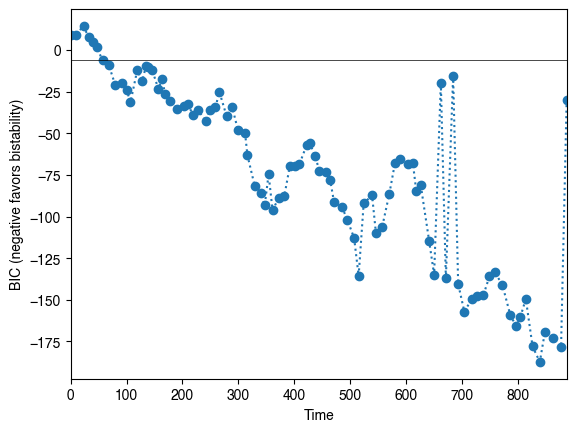

In [102]:
# 240123 smaller timestep
plt.plot(t_min_list,[data['bicDiff'] for data in landauDataList],'o:')
tmin,tmax = 0,max(t_min_list)
plt.hlines(-6,tmin,tmax,color='k',lw=0.5) # plot horizontal line at -6
plt.axis(xmin=tmin,xmax=tmax)
plt.xlabel('Time')
plt.ylabel('BIC (negative favors bistability)');

We are still refining how to best select the correct time here to look for control genes.  Most naively, we might try the first time window in which BIC becomes less than -6.

In [103]:
first_bistable_time_index = [data['bicDiff'] < -6 for data in landauDataList].index(True)
print("The first evidence for bistability happens at time = {:.3f}".format(t_min_list[first_bistable_time_index]))

The first evidence for bistability happens at time = 57.000


Our current hypothesis is that, at this time of first bistability, the genes with the largest proportion of their variance along the principal component (a number we call $s$) are the most likely control nodes.

In [104]:
def s(expression_data,Jnu):
    """
    Compute the proportion of variance for each gene along the principal component.
    
    Currently takes as input `Jnu` from landauAnalysis.  Could probably compute that here
    so we don't have to rely on landauAnalysis code.
    """
    vals,vecs = landauAnalysis.principalComponents(expression_data)
    pc = pd.Series(vecs[0], index=expression_data.columns)
    variances = pd.Series(np.diag(expression_data.cov(ddof=0)), index=expression_data.columns)
    return pc**2 / Jnu / variances

In [105]:
# another possibility is that the relevant number for each gene is its contribution to the principal component
# (e.g. which gene, when forced on or off, pushes me furthest along the PC?)
def principal_component_contributions(expression_data):
    """
    Compute the contribution of each gene to the principal component.
    
    The contribution is equal to the absolute value of the principal eigenvector.
    """
    vals,vecs = landauAnalysis.principalComponents(expression_data)
    pc = pd.Series(vecs[0], index=expression_data.columns)
    return np.abs(pc)

In [137]:
# compute s values for all time windows
# as well as principal component contributions for all time windows
sList,pcContributionsList = [],[]
for timeIndex in range(len(t_min_list)):
    expression_slice = expression.loc[cells_to_use_list[timeIndex]]
    Jnu = landauDataList[timeIndex]['vals'][0]
    sList.append(s(expression_slice,Jnu))
    pcContributionsList.append(principal_component_contributions(expression_slice))

The predicted control node(s) are the ones with largest $s$ at the relevant time window:

In [110]:
print('Genes sorted by s at first bistable time:')
sList[first_bistable_time_index].sort_values(ascending=False)

Genes sorted by s at first bistable time:


g4    2.927284
g3    2.846170
g1    2.732793
g2    0.309198
g5    0.070944
dtype: float64

In [111]:
print('Genes sorted by PC contribution at first bistable time:')
pcContributionsList[first_bistable_time_index].sort_values(ascending=False)

Genes sorted by PC contribution at first bistable time:


g3    0.681799
g1    0.655434
g4    0.314212
g2    0.070057
g5    0.043819
dtype: float64

# 2024/3/20 how often do we correctly predict control kernel genes?

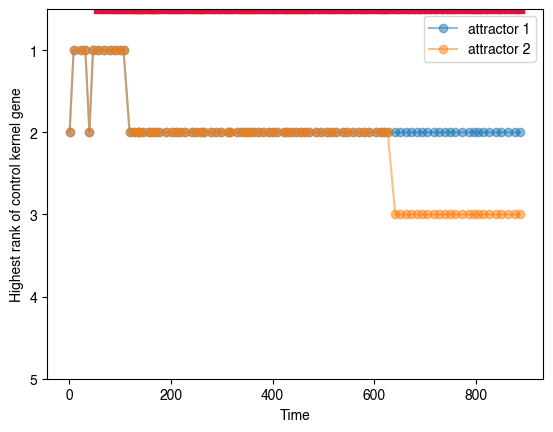

In [118]:
# 250123
# (see cell-collective-control-kernel-genes.ipynb for code to calculate all control kernels of size 1)
control_kernel_genes = {'attractor 1': ['g2','g3','g4'],
                        'attractor 2': ['g3'],
                       }

# plot minimum ranks as a function of time for each attractor
for attractor_name in control_kernel_genes.keys():
    # using s ranking
    # min_rank_vs_t = [ min([s.rank(ascending=False)[gene] for gene in control_kernel_genes[attractor_name]]) for s in sList ]
    # plt.plot(t_min_list,min_rank_vs_t,label=attractor_name,marker='o',alpha=0.5)

    # using principal component contribution ranking
    min_pc_rank_vs_t = [ min([pcContributions.rank(ascending=False)[gene] for gene in control_kernel_genes[attractor_name]]) \
                         for pcContributions in pcContributionsList ]
    plt.plot(t_min_list,min_pc_rank_vs_t,label=attractor_name,marker='o',alpha=0.5)

# indicate which cases show evidence of bistability
BICthresh = -6
yVal = 0.5
plt.plot(t_min_list,
         [(landauData['bicDiff'] < BICthresh)*yVal for landauData in landauDataList],
         's',
         zorder=-10,
         color='crimson')

plt.xlabel('Time')
plt.ylabel('Highest rank of control kernel gene')
plt.axis(ymin=yVal) #,xmax=100)
plt.yticks(range(1,len(expression.columns)+1))
plt.gca().invert_yaxis()
plt.legend()

# visualize the data

In [124]:
def principal_component_projections(expression_data):
    """
    Compute the projections of each cell's expression onto the first principal component.
    """
    vals,vecs = landauAnalysis.principalComponents(expression_data,k=1)
    vt = np.transpose(vecs[0])
    return pd.Series(np.dot(expression_slice-expression_slice.mean(),vt),index=expression_data.index)

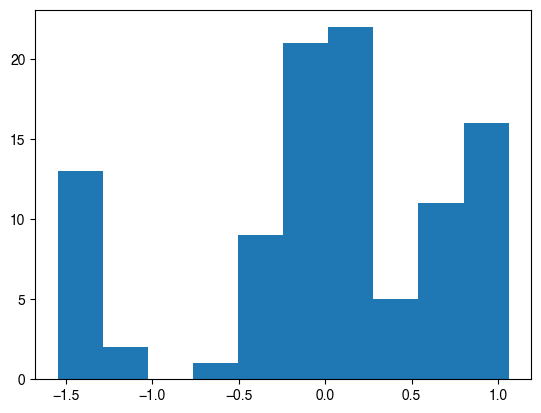

In [147]:
# projections along principal components of single time windows
timeIndex = first_bistable_time_index + 0
expression_slice = expression.loc[cells_to_use_list[timeIndex]]
proj = principal_component_projections(expression_slice)
plt.hist(proj);

# output to file to use with testing new landau fitting
#np.savetxt('240327_test_fitting_expression_data.txt',expression_slice)
#np.savetxt('240322_test_fitting_data.txt',proj)

In [136]:
def plot_model(landauData,xmin,xmax,mu,Jnu):
    c,h,d,numu = landauData['c'],landauData['h'],landauData['d'],landauData['nuMu']
    Z = landauAnalysis.normalizationZ(Jnu,c,h,d)
    
    fit_distribution = [ np.exp(landauAnalysis.LandauTransitionDistributionRelativeLogPDF(x-numu,mu,Jnu,c,h,d))/Z for x in xs ]
    plt.plot(xs,fit_distribution,lw=5)

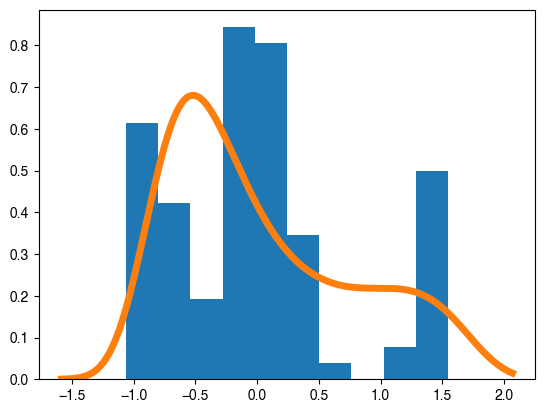

In [180]:
# plot data histogram along principal component
timeIndex = first_bistable_time_index - 0
expression_slice = expression.loc[cells_to_use_list[timeIndex]]
proj = landauAnalysis.principal_component_proj(expression_slice)
plt.hist(proj,density=True,bins=int(np.sqrt(len(proj))))

# plot model(s)
xpad = (max(proj)-min(proj))/5.
xmin,xmax = min(proj)-xpad,max(proj)+xpad
xs = np.linspace(xmin,xmax,1000)
mu = np.mean(proj)
Jnu = 1./np.var(proj)
fit = landauDataList[timeIndex]
plot_model(fit,xmin,xmax,mu,Jnu)
#fit_noBias = landauDataList_noBias[timeIndex]
#plot_model(fit_noBias,xmin,xmax,mu,Jnu)

Text(0, 0.5, 'Second principal component')

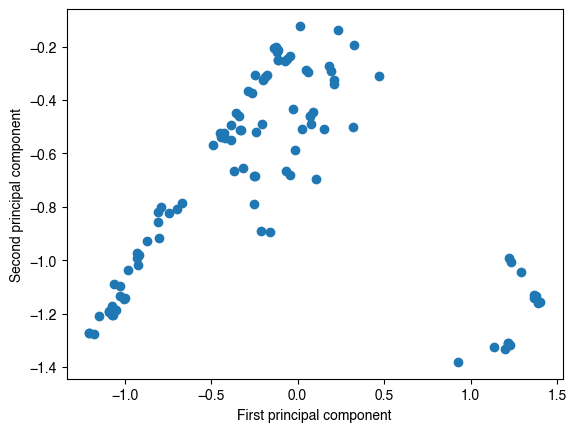

In [163]:
timeIndex = first_bistable_time_index - 0
expression_slice = expression.loc[cells_to_use_list[timeIndex]]
vals,vecs = landauAnalysis.principalComponents(expression_slice)
projected0 = expression_slice.dot(vecs[0])
projected1 = expression_slice.dot(vecs[1])

plt.scatter(projected0,projected1)#,c=times,cmap='copper')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

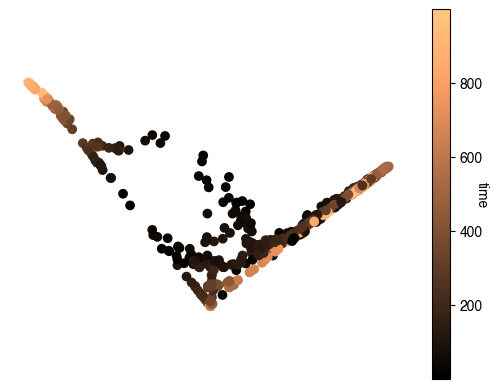

In [164]:
# PCA
vals,vecs = landauAnalysis.principalComponents(expression)
projected0 = expression.dot(vecs[0])
projected1 = expression.dot(vecs[1])

plt.scatter(projected0,projected1,c=times,cmap='copper')
cbar = plt.colorbar()
cbar.set_label('time',rotation=270)
plt.axis('equal')
plt.axis('off');

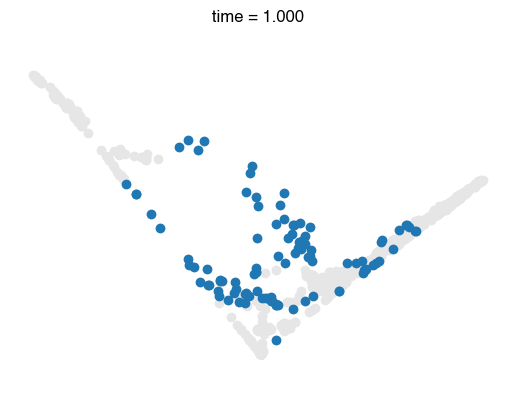

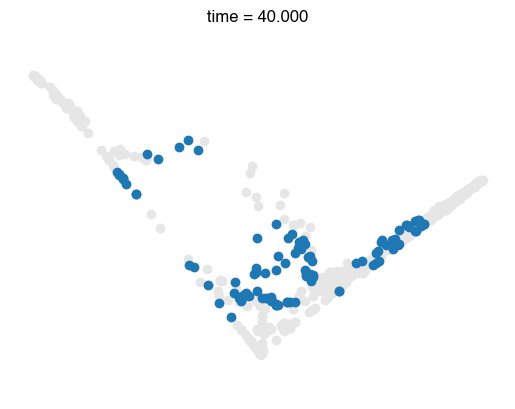

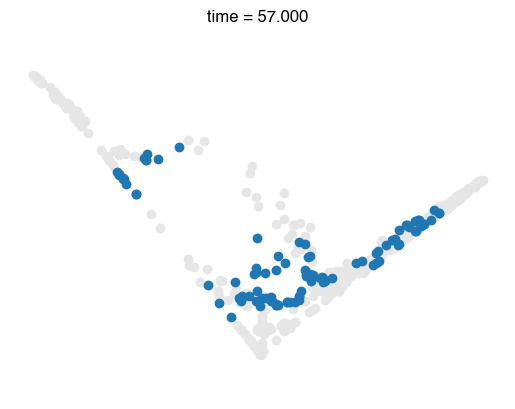

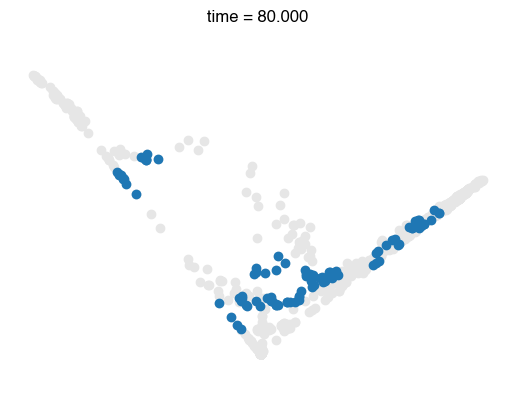

In [167]:
# plot cells from individual time windows on the original PCA axes
time_index_list = first_bistable_time_index + np.array([-6,-2,0,2]) 
for time_index in time_index_list:
    plt.figure()
    plt.scatter(projected0,
                projected1,
                c='0.9')
    plt.scatter(projected0[cells_to_use_list[time_index]],
                projected1[cells_to_use_list[time_index]],
                c='C0')
    plt.axis('equal')
    plt.axis('off')
    plt.title("time = {:.3f}".format(t_min_list[time_index]))

# Do we get the right attractors?

Looks like we are not all the way to the attractor states yet?  We might be able to characterize these states in terms of how far they are from attractors?  Or show somehow that they are deep enough in basins that they will never switch to another basin?  (Related to Enrico's ideas about characterizing states in terms of their likelihoods to end up at different attractor states)

In [179]:
((expression.loc[cells_to_use_list[-1]] > 0.2)*1).iloc[-20:]

,g1,g2,g3,g4,g5
E0_969,1,0,0,0,0
E0_970,1,0,0,0,0
E0_970.1,1,0,0,0,0
E0_972,0,0,1,1,1
E0_973,1,0,0,0,0
E0_975,0,0,0,0,0
E0_976,1,0,0,0,0
E0_977,1,0,0,0,0
E0_977.1,1,0,0,0,0
E0_978,1,0,0,0,0


# old as of 2025/1/23

In [100]:
min([data['d'] for data in landauDataList])

0.1

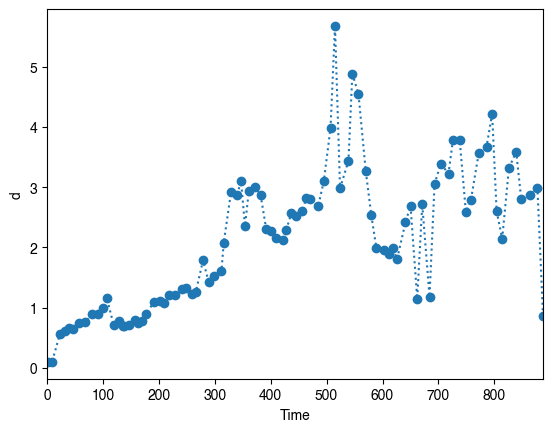

In [101]:
# 2025/1/23
plt.plot(t_min_list,[data['d'] for data in landauDataList],'o:')
tmin,tmax = 0,max(t_min_list)
plt.axis(xmin=tmin,xmax=tmax)
plt.xlabel('Time')
plt.ylabel('d');

In [11]:
landauDataList_noBias = []
for cells_to_use in tqdm(cells_to_use_list):
    landauData = landauAnalysis.landauAnalysis(expression.loc[cells_to_use],include_bias=False)
    landauDataList_noBias.append(landauData)

100%|███████████████████████████████████████████| 90/90 [01:23<00:00,  1.08it/s]


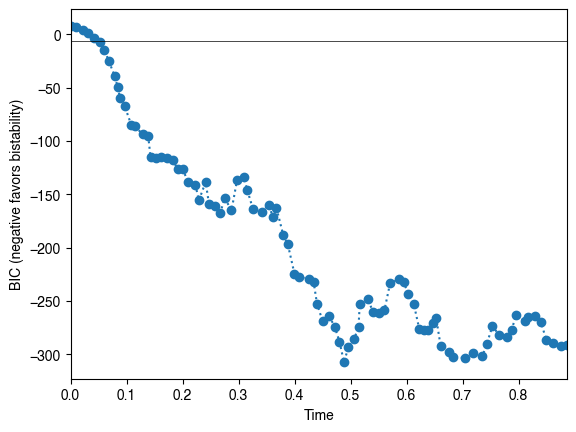

In [32]:
# 2025/1/22 using data that starts from a single initial condition
plt.plot(t_min_list,[data['bicDiff'] for data in landauDataList_oneIC],'o:')
tmin,tmax = 0,max(t_min_list)
plt.hlines(-6,tmin,tmax,color='k',lw=0.5) # plot horizontal line at -6
plt.axis(xmin=tmin,xmax=tmax)
plt.xlabel('Time')
plt.ylabel('BIC (negative favors bistability)');

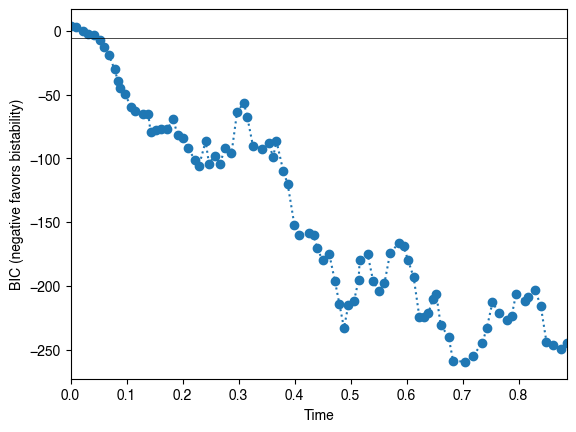

In [34]:
# 2025/1/22 using data that starts from a single initial condition, with no bias
plt.plot(t_min_list,[data['bicDiff'] for data in landauDataList_oneIC_noBias],'o:')
tmin,tmax = 0,max(t_min_list)
plt.hlines(-6,tmin,tmax,color='k',lw=0.5) # plot horizontal line at -6
plt.axis(xmin=tmin,xmax=tmax)
plt.xlabel('Time')
plt.ylabel('BIC (negative favors bistability)');

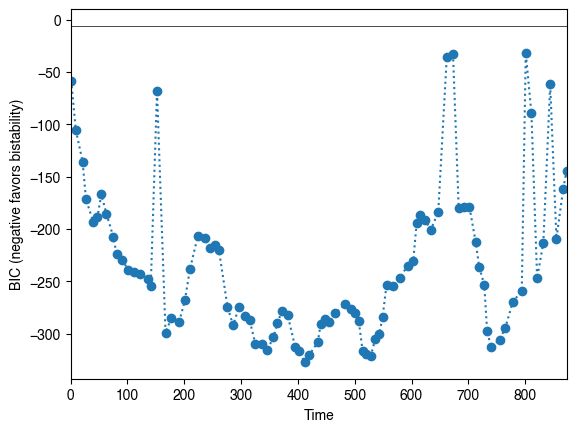

In [60]:
# using 240320 data (with larger timestep)
plt.plot(t_min_list,[data['bicDiff'] for data in landauDataList],'o:')
tmin,tmax = 0,max(t_min_list)
plt.hlines(-6,tmin,tmax,color='k',lw=0.5) # plot horizontal line at -6
plt.axis(xmin=tmin,xmax=tmax)
plt.xlabel('Time')
plt.ylabel('BIC (negative favors bistability)');

Text(0.5, 1.0, 'No bias ($h=0$)')

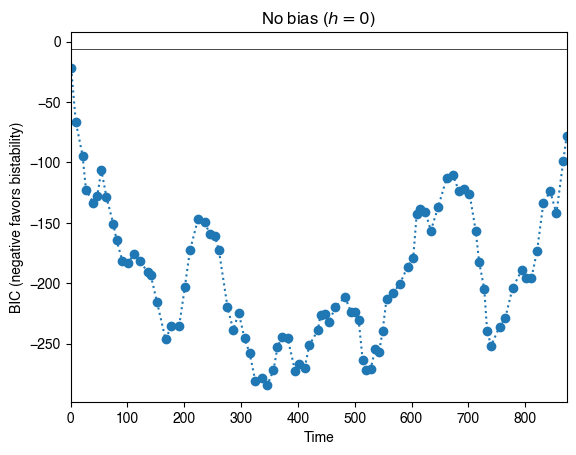

In [14]:
plt.plot(t_min_list,[data['bicDiff'] for data in landauDataList_noBias],'o:')
tmin,tmax = 0,max(t_min_list)
plt.hlines(-6,tmin,tmax,color='k',lw=0.5) # plot horizontal line at -6
plt.axis(xmin=tmin,xmax=tmax)
plt.xlabel('Time')
plt.ylabel('BIC (negative favors bistability)');
plt.title("No bias ($h=0$)")

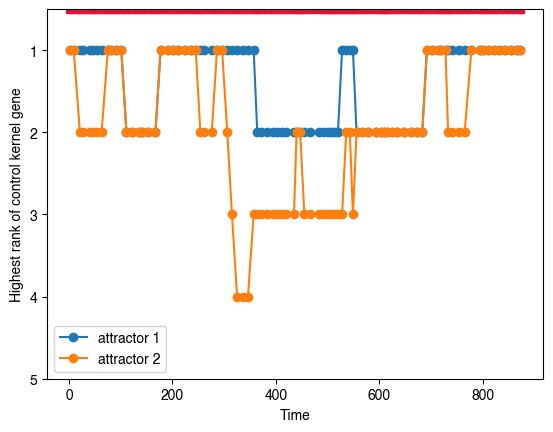

In [69]:
# using 240320 data (with larger timestep)
# (see cell-collective-control-kernel-genes.ipynb for code to calculate all control kernels of size 1)
control_kernel_genes = {'attractor 1': ['g2','g3','g4'],
                        'attractor 2': ['g3'],
                       }

# plot minimum ranks as a function of time for each attractor
for attractor_name in control_kernel_genes.keys():
    min_rank_vs_t = [ min([s.rank(ascending=False)[gene] for gene in control_kernel_genes[attractor_name]]) for s in sList ]
    plt.plot(t_min_list,min_rank_vs_t,label=attractor_name,marker='o')

# indicate which cases show evidence of bistability
BICthresh = -6
yVal = 0.5
plt.plot(t_min_list,
         [(landauData['bicDiff'] < BICthresh)*yVal for landauData in landauDataList],
         's',
         zorder=-10,
         color='crimson')

plt.xlabel('Time')
plt.ylabel('Highest rank of control kernel gene')
plt.axis(ymin=yVal)
plt.yticks(range(1,len(expression.columns)+1))
plt.gca().invert_yaxis()
plt.legend()